### Импорт

In [1]:
import pandas as pd
import statsmodels.api as sm
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model # Linear Regression (OLS)
from sklearn import tree # Decision Tree
from sklearn import svm # Support Vector Machines (SVM)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

df_metrics=pd.DataFrame() # Датафрейм для сбора метрик

### Функции

In [2]:
def delete_outliers (df, column_name): # Функция удаления выбросов из датафрейма методом IRQ
    '''
    Parameters
    ----------
    df: source DataFrame from which outliers are to be removed
    column_name: name of the column to be checked for outliers
    
    Return: Dataframe without outliers in column_name
    '''
    q1=df[column_name].quantile(0.25)
    q3=df[column_name].quantile(0.75)
    d=1.5*(q3-q1)
    lower_bound=q1-d
    upper_bound=q3+d
    print (f"Найдено и удалено {df[(df[column_name]<lower_bound)|(df[column_name]>upper_bound)].shape[0]} выброс(а/ов) в столбце {column_name}")
    return df[(df[column_name]>=lower_bound)&(df[column_name]<=upper_bound)] # включая концы

def chi2_result(a, x, text): 
    cr=ss.chi2_contingency(x) # У этого теста нулевая гипотеза говорит, что между двумя категориальными переменными зависимости нет
    p=cr.pvalue
    f=f"Результат теста Пирсона (Хи-квадрат) о взаимосвязи {text}: statistic={cr.statistic:.3f}, p-value={p:.5f}\n"
    if p<a:
        f+="p-value<alpha -> Существует значимая зависимость\n"
    else:
        f+="p-value>=alpha -> Значимой зависимости нет\n"
    return f

def ttest_result(a, x, y, text):
    tr=ss.ttest_ind(x, y)
    p=tr.pvalue
    f=f"Результат теста на значимость разницы {text}: statistic={tr.statistic:.3f}, p-value={p:.5f}\n"
    if p<a:
        f+="p-value<alpha -> Есть отличия"
    else:
        f+="p-value>=alpha -> Нет отличия"
    return f


def shapiro_result(a, x, text):
    sr=ss.shapiro(x)
    p=sr.pvalue
    f=f"Результат теста с использованием критерия Шапиро-Уилка {text}: statistic={sr.statistic:.3f}, p-value={p:.5f}\n"
    if p<a:
        f+="p-value<alpha -> Распределение не является нормальным\n"
    else:
        f+="p-value>=alpha -> Распределение является нормальным\n"
    return f

def anderson_result(a, x, text):
    a=a*100
    ar=ss.anderson(x)
    s=ar.statistic
    cv=ar.critical_values
    sl=ar.significance_level
    if (a in sl):
        ccv=cv[sl.tolist().index(a)]
        f=f"Результат теста с использованием критерия Андерсона-Дарлинга {text}: statistic={s:.3f}, critical_values={cv}, significance level={sl}\n"
        if (s>ccv):
            f+="Значение статистики превышает критическое значение -> Распределение не является нормальным\n"
        else:
            f+="Значение статистики не превышает критическое значение -> Распределение является нормальным\n"
        return f
    else:
        return f"Не удалось найти критическое значение для уровня значимости {a}%"

def ks_result(a, x, text):
    loc, scale = ss.norm.fit(x) # Определяем параметры распределения
    norm_dist = ss.norm(loc=loc, scale=scale) # Создаем нормальное распределение с данными параметрами
    kr=ss.kstest(x, norm_dist.cdf)
    p=kr.pvalue
    f=f"Результат теста Колмогорова-Смирнова {text}: statistic={kr.statistic:.3f}, p-value={p:.5f}, statistic location={kr.statistic_location:.3f}, statistic sign={kr.statistic_sign:.3f}\n"
    if p<a:
        f+="p-value<alpha -> Распределение не является нормальным\n"
    else:
        f+="p-value>=alpha -> Распределение является нормальным\n"
    return f

def alt_method(x, text): # Дополнительные проверки на нормальность распределения
    mean=x.mean()
    median=x.median()
    d=mean-median
    skew=ss.skew(x)
    kurtosis=ss.kurtosis(x)
    if d!=0:
        cmp="отличается от медианного"
    else:
        cmp_str="равно медианному"
    return f"Среднее значение {text} ({mean:.2f}) {cmp} ({median:.2f}), скошенность: {skew:.2f}, эксцесс:{kurtosis:0.2f}"

def model_metrics(test, pred, text): # Метрики качества модели регрессии
    r2=r2_score(test, pred)
    mae=mean_absolute_error(test, pred)
    rmse=np.sqrt(mean_squared_error(test, pred))
    mape=mean_absolute_percentage_error(test, pred)
    return pd.DataFrame([{'TEXT':text, 'R2':r2, 'MAE':mae, 'RMSE':rmse, 'MAPE':mape}])

def model_test(m, text, X_tr, y_tr, X_t, y_t): # Функция тестирования модели
    global df_metrics
    m.fit(X_tr, y_tr)
    y_pred = m.predict(X_t)
    plt.scatter(y_t, y_pred)
    plt.show()
    d = model_metrics(y_t, y_pred, text)
    if df_metrics.size!=0:
        df_metrics=pd.concat([df_metrics, d], axis=0)
    else:
        df_metrics=d
    print (f"Метрики:\n{d}\n")
    return y_pred

def split_selection(X_matrix, y): # Функция разбиения выборки в соответствии с заданием
    rs=32
    X_train, X_test, y_train, y_test=train_test_split(X_matrix, y, test_size=0.4, random_state=rs) # в test пока 40%
    X_test, X_forecast, y_test, y_forecast=train_test_split(X_test, y_test, test_size=0.5, random_state=rs) # делим тестовую выборку попалам
    return X_train, y_train, X_test, y_test, X_forecast, y_forecast

lambda_norm = lambda x: (x-x.min())/(x.max()-x.min()) # Функция для нормализации

### Загрузка данных

Документация - https://vincentarelbundock.github.io/Rdatasets/doc/AER/CollegeDistance.html

In [3]:
item = 'CollegeDistance' # Выбрать из поля Item для вашего датасета
package = 'AER' # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package , cache=True).data
df.head()

,gender,ethnicity,score,fcollege,mcollege,home,urban,unemp,wage,distance,tuition,education,income,region
rownames,,,,,,,,,,,,,,
1,male,other,39.150002,yes,no,yes,yes,6.2,8.09,0.2,0.88915,12,high,other
2,female,other,48.869999,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
3,male,other,48.740002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
4,male,afam,40.400002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
5,female,other,40.480000,no,no,no,yes,5.6,8.09,0.4,0.88915,13,low,other


### Разведочный анализ данных

In [4]:
print (f"Размер датафрейма:\n{df.shape}\n")
print (f"Типы данных в столбцах:\n{df.dtypes}\n")
print (f"Уникальные значения в столбце 'gender':{df['gender'].unique()}") # factor indicating gender
print (f"Уникальные значения в столбце 'ethnicity':{df['ethnicity'].unique()}") # factor indicating ethnicity (African-American, Hispanic or other)
print (f"Уникальные значения в столбце 'fcollege':{df['fcollege'].unique()}") # factor. Is the father a college graduate?
print (f"Уникальные значения в столбце 'mcollege':{df['mcollege'].unique()}") # factor. Is the mother a college graduate?
print (f"Уникальные значения в столбце 'home':{df['home'].unique()}") # factor. Does the family own their home?
print (f"Уникальные значения в столбце 'urban':{df['urban'].unique()}") # factor. Is the school in an urban area?
print (f"Уникальные значения в столбце 'income':{df['income'].unique()}") # factor. Is the family income above USD 25,000 per year?
print (f"Уникальные значения в столбце 'region':{df['region'].unique()}") # factor indicating region (West or other)

print (f"Информация о числовых переменных:\n{df.describe()}\n")
# score - base year composite test score. These are achievement tests given to high school seniors in the sample
# unemp - county unemployment rate in 1980
# wage - state hourly wage in manufacturing in 1980
# distance - distance from 4-year college (in 10 miles)
# tuition - average state 4-year college tuition (in 1000 USD)
# education - number of years of education

Размер датафрейма:
(4739, 14)

Типы данных в столбцах:
gender        object
ethnicity     object
score        float64
fcollege      object
mcollege      object
home          object
urban         object
unemp        float64
wage         float64
distance     float64
tuition      float64
education      int64
income        object
region        object
dtype: object

Уникальные значения в столбце 'gender':['male' 'female']
Уникальные значения в столбце 'gender':['other' 'afam' 'hispanic']
Уникальные значения в столбце 'fcollege':['yes' 'no']
Уникальные значения в столбце 'mcollege':['no' 'yes']
Уникальные значения в столбце 'home':['yes' 'no']
Уникальные значения в столбце 'urban':['yes' 'no']
Уникальные значения в столбце 'income':['high' 'low']
Уникальные значения в столбце 'region':['other' 'west']
Информация о числовых переменных:
             score        unemp         wage     distance      tuition  \
count  4739.000000  4739.000000  4739.000000  4739.000000  4739.000000   
mean     50

### Выдвижение гипотез

1. home и income находятся в прямой зависимости, так как семьи с высоким уровнем дохода с большей вероятностью могут себе позволить собственный дом.
2. score и urban находятся в прямой зависимости, так как в городской местности больше возможностей для получения качественного образования.
3. tuition и wage находятся в прямой зависимости, так как большая зарплата - большие издержки -> увеличение стоимости обучения.

### Подготовка датафрейма

In [5]:
#Проверка на дубликаты и их удаление в случае наличия
dups=df.duplicated().sum()
print (f"Найдено {dups} дубликатов")
if dups>0:
    df=df.drop_duplicates()
    print ("Произведено удаление дубликатов")

# Проверка на пропуски
n_miss=df.isna().sum().sum()
print (f"Найдено {n_miss} пропусков")
if n_miss>0: # Удаление пропусков
    df.dropna(inplace=True)
    print("Пропуски были удалены")

# Удаление выбросов из необходимых столбцов
df=delete_outliers(df, 'score')
df=delete_outliers(df, 'tuition')
df=delete_outliers(df, 'wage')

print (f"\nПодготовленный датафрейм:\n{df}")

Найдено 0 дубликатов
Найдено 0 пропусков
Найдено и удалено 0 выброс(а/ов) в столбце score
Найдено и удалено 0 выброс(а/ов) в столбце tuition
Найдено и удалено 272 выброс(а/ов) в столбце wage

Подготовленный датафрейм:
          gender ethnicity      score fcollege mcollege home urban  unemp  \
rownames                                                                    
1           male     other  39.150002      yes       no  yes   yes    6.2   
2         female     other  48.869999       no       no  yes   yes    6.2   
3           male     other  48.740002       no       no  yes   yes    6.2   
4           male      afam  40.400002       no       no  yes   yes    6.2   
5         female     other  40.480000       no       no   no   yes    5.6   
...          ...       ...        ...      ...      ...  ...   ...    ...   
9391        male      afam  56.529999       no       no  yes    no    6.6   
9401        male      afam  59.770000       no       no  yes    no    6.6   
9411        

### Сбор статистик

In [6]:
print (f"Распределение семей, имеющих собственные дома (%):\n{100*df['home'].value_counts(normalize=True)}\n")
print (f"Распределение семей с годовым доходом выше 25 000 $ (%):\n{100*df['income'].value_counts(normalize=True)}\n")
print (f"Распределение школ в городской местности (%):\n{100*df['urban'].value_counts(normalize=True)}\n")
print (f"Описательная статистика для результатов тестирования:\n{ss.describe(df['score'])}\n")
print (f"Описательная статистика для средней стоимости обучения:\n{ss.describe(df['tuition'])}\n")
print (f"Описательная статистика для запрлаты в штате:\n{ss.describe(df['wage'])}\n")

Распределение семей, имеющих собственные дома (%):
home
yes    81.553615
no     18.446385
Name: proportion, dtype: float64

Распределение семей с годовым доходом выше 25 000 $ (%):
income
low     71.815536
high    28.184464
Name: proportion, dtype: float64

Распределение школ в городской местности (%):
urban
no     76.203268
yes    23.796732
Name: proportion, dtype: float64

Описательная статистика для результатов тестирования:
DescribeResult(nobs=4467, minmax=(np.float64(28.950000762939453), np.float64(72.80999755859375)), mean=np.float64(50.82325946593514), variance=np.float64(75.77873693201954), skewness=np.float64(-0.020141876955069762), kurtosis=np.float64(-0.8802259327324085))

Описательная статистика для средней стоимости обучения:
DescribeResult(nobs=4467, minmax=(np.float64(0.2575100064277649), np.float64(1.4041600227355957)), mean=np.float64(0.8030667597078119), variance=np.float64(0.11702450410315614), skewness=np.float64(-0.09840742944854612), kurtosis=np.float64(-1.0538507

### Визуализация

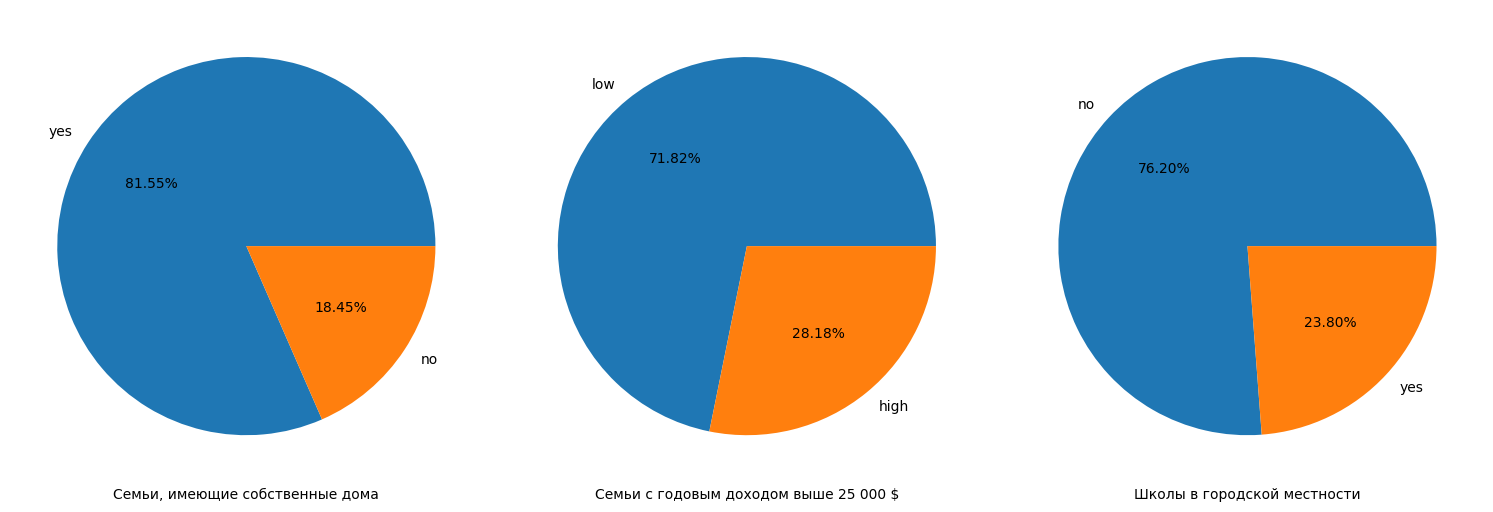

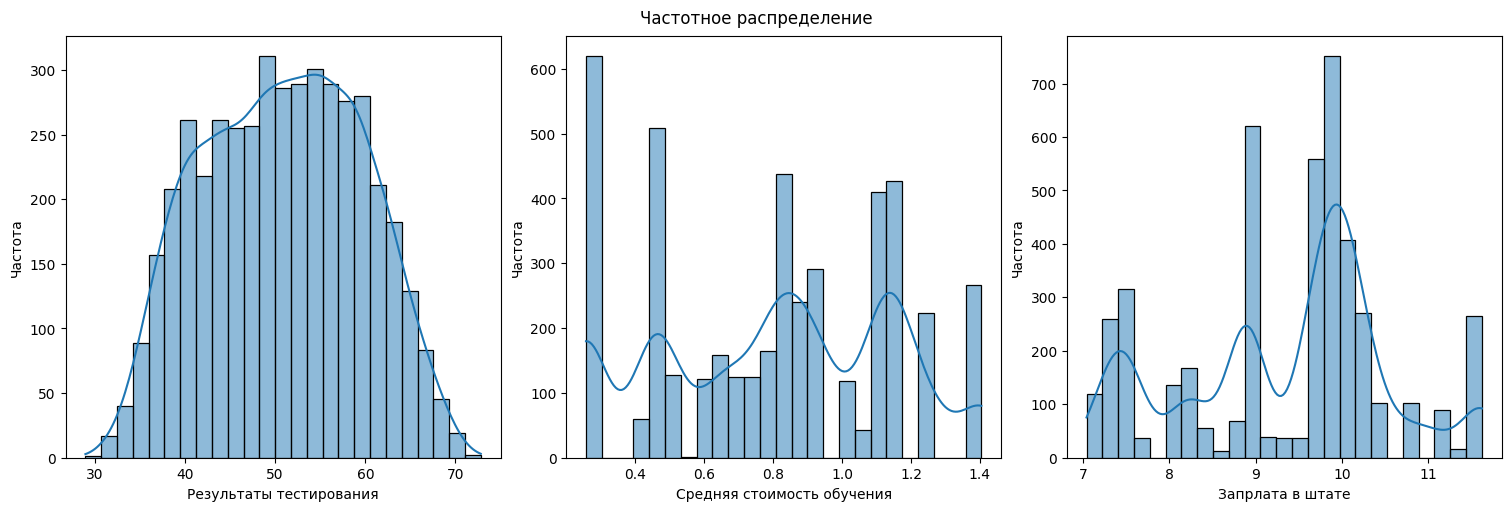

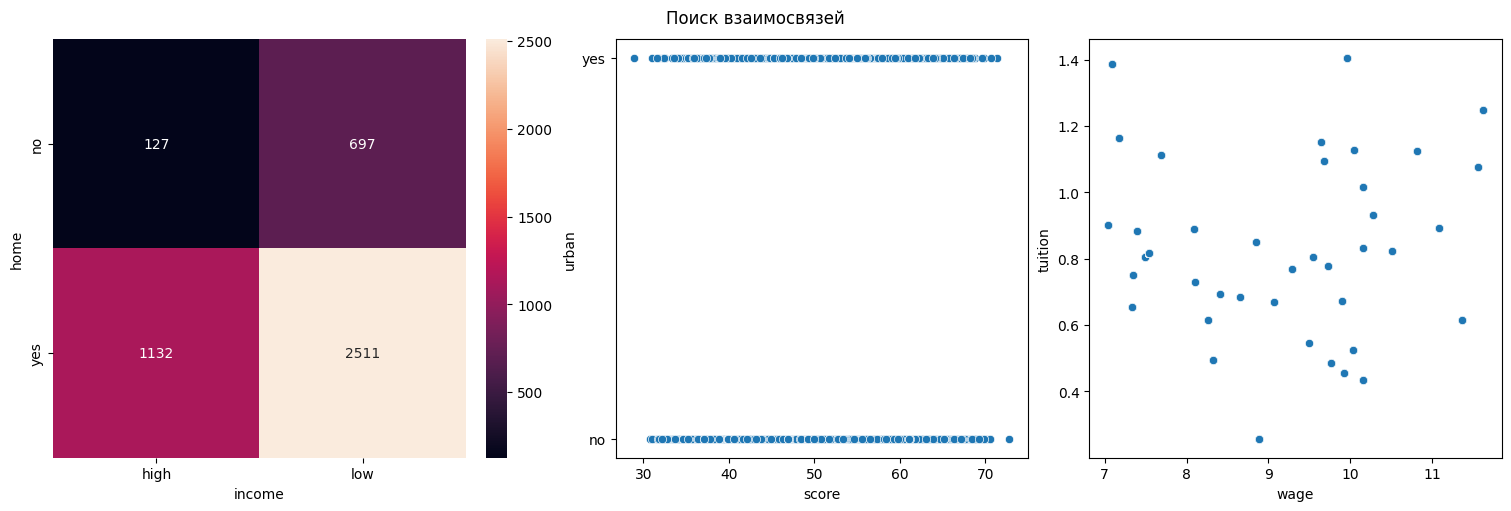

Таблица кросс-табуляции для столбцов 'home' и 'income':
income  high   low
home              
no       127   697
yes     1132  2511


In [7]:
# графики, гистограммы и таблица

fig, ax=plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)
ax[0].pie(df['home'].value_counts(normalize=True).values, labels = df['home'].value_counts(normalize=True).index, autopct = '%0.2f%%')
ax[0].set_xlabel('Семьи, имеющие собственные дома')
ax[1].pie(df['income'].value_counts(normalize=True).values, labels = df['income'].value_counts(normalize=True).index, autopct = '%0.2f%%')
ax[1].set_xlabel('Семьи с годовым доходом выше 25 000 $')
ax[2].pie(df['urban'].value_counts(normalize=True).values, labels = df['urban'].value_counts(normalize=True).index, autopct = '%0.2f%%')
ax[2].set_xlabel('Школы в городской местности')
plt.show()

fig, ax=plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)
fig.suptitle('Частотное распределение')
sns.histplot(data=df['score'], bins=25, kde=True, ax=ax[0])
sns.histplot(data=df['tuition'], bins=25, kde=True, ax=ax[1])
sns.histplot(data=df['wage'], bins=25, kde=True, ax=ax[2])
ax[0].set_xlabel('Результаты тестирования')
ax[0].set_ylabel('Частота')
ax[1].set_xlabel('Средняя стоимость обучения')
ax[1].set_ylabel('Частота')
ax[2].set_xlabel('Запрлата в штате')
ax[2].set_ylabel('Частота')
plt.show()

df_heatmap=pd.crosstab(df['home'], df['income'])

fig, ax=plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)
fig.suptitle('Поиск взаимосвязей')
sns.heatmap(data=df_heatmap, annot=True, fmt='.0f',  ax=ax[0])
sns.scatterplot(data = df, x = 'score', y = 'urban', ax=ax[1])
sns.scatterplot(data = df, x = 'wage', y = 'tuition', ax=ax[2])

plt.show()
print (f"Таблица кросс-табуляции для столбцов 'home' и 'income':\n{df_heatmap}")

### Тесты score на нормальность


Уровень доверия: 0.95
Уровень значимости (вероятность ошибки первого рода): 0.05
Визаульный анализ гистограммы для score дает основание сделать вывод о том, что распределение близко к нормальному. Проведем ряд тестов
Результат теста с использованием критерия Шапиро-Уилка для score: statistic=0.983, p-value=0.00000
p-value<alpha -> Распределение не является нормальным

Результат теста с использованием критерия Андерсона-Дарлинга для score: statistic=18.964, critical_values=[0.575 0.655 0.786 0.917 1.091], significance level=[15.  10.   5.   2.5  1. ]
Значение статистики превышает критическое значение -> Распределение не является нормальным

Результат теста Колмогорова-Смирнова для score: statistic=0.042, p-value=0.00000, statistic location=44.160, statistic sign=1.000
p-value<alpha -> Распределение не является нормальным

Все 3 теста отвергают нормальное распределение


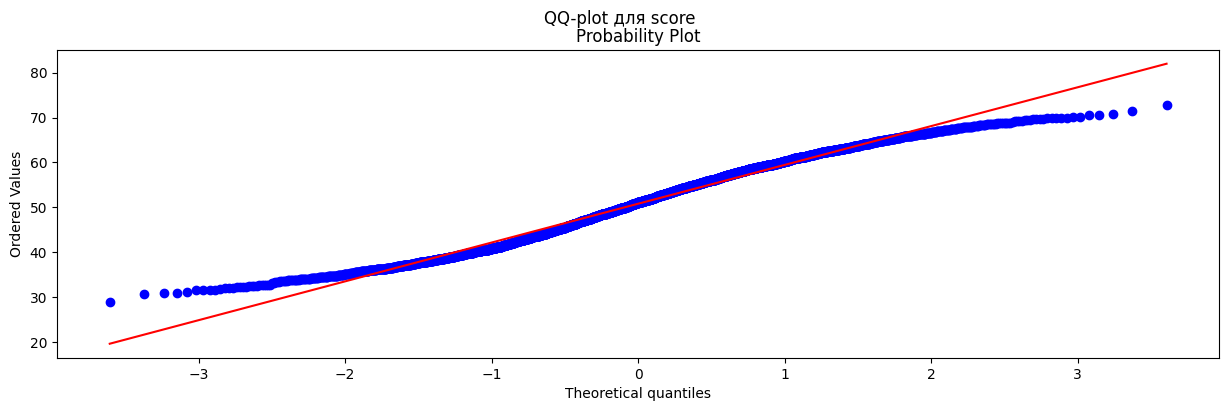

Попробуем перейти к логонормальному распределению


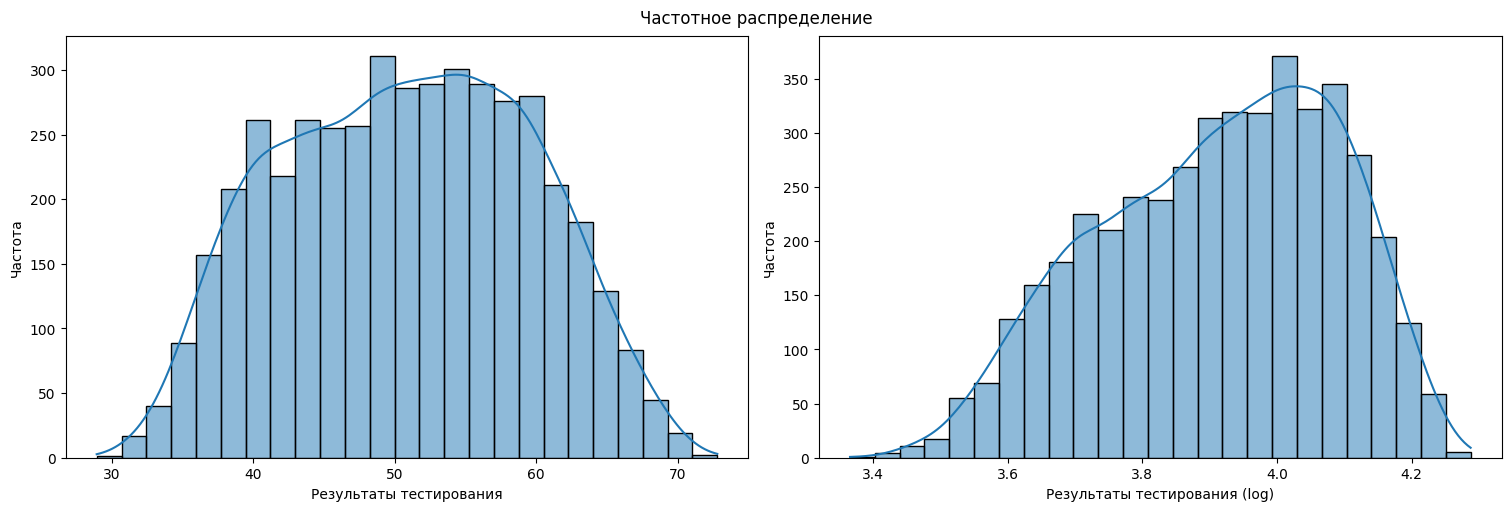

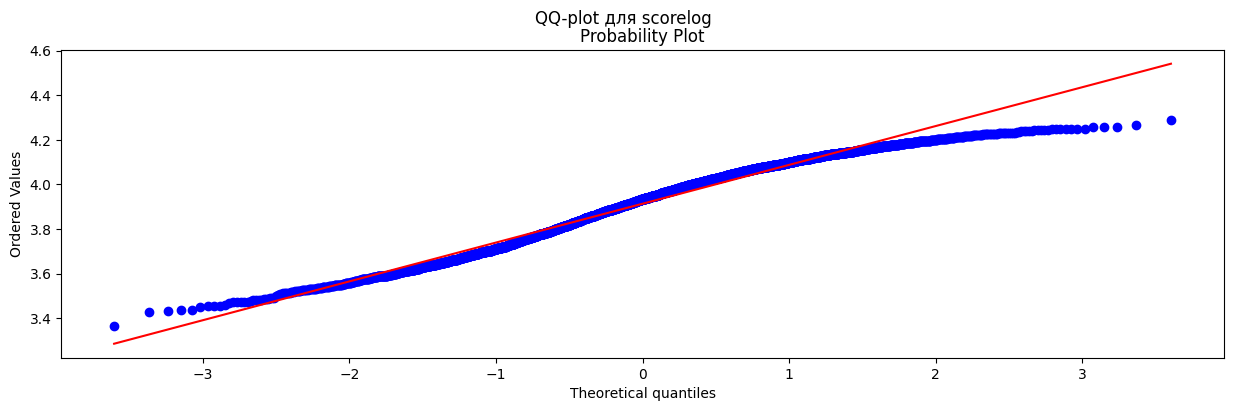

Результат теста с использованием критерия Шапиро-Уилка для scorelog: statistic=0.976, p-value=0.00000
p-value<alpha -> Распределение не является нормальным

Результат теста с использованием критерия Андерсона-Дарлинга для scorelog: statistic=29.924, critical_values=[0.575 0.655 0.786 0.917 1.091], significance level=[15.  10.   5.   2.5  1. ]
Значение статистики превышает критическое значение -> Распределение не является нормальным

Результат теста Колмогорова-Смирнова для scorelog: statistic=0.057, p-value=0.00000, statistic location=3.992, statistic sign=-1.000
p-value<alpha -> Распределение не является нормальным

Тесты и графический анализ отвергают также логонормальное распределение

Применим дополнительные методы
Среднее значение score (50.82) отличается от медианного (51.10), скошенность: -0.02, эксцесс:-0.88
Среднее значение scorelog (3.91) отличается от медианного (3.93), скошенность: -0.32, эксцесс:-0.74


In [8]:
confidence=0.95 # Уровень доверия
print (f"\nУровень доверия: {confidence:.2f}")
alpha=np.round(1-confidence, 2)
print (f"Уровень значимости (вероятность ошибки первого рода): {alpha:.2f}")

print ("Визаульный анализ гистограммы для score дает основание сделать вывод о том, что распределение близко к нормальному. Проведем ряд тестов")
print (shapiro_result(alpha, df['score'], "для score"))
print (anderson_result(alpha, df['score'], "для score"))
print (ks_result(alpha, df['score'], "для score"))
print ("Все 3 теста отвергают нормальное распределение")

fig, ax=plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle('QQ-plot для score')
ss.probplot(df['score'], dist='norm', plot=ax)
plt.show()

print ('Попробуем перейти к логонормальному распределению')
df['scorelog']=df['score'].apply(np.log)

fig, ax=plt.subplots(ncols=2, figsize=(15, 5), constrained_layout=True)
fig.suptitle('Частотное распределение')
sns.histplot(data=df['score'], bins=25, kde=True, ax=ax[0])
sns.histplot(data=df['scorelog'], bins=25, kde=True, ax=ax[1])
ax[0].set_xlabel('Результаты тестирования')
ax[0].set_ylabel('Частота')
ax[1].set_xlabel('Результаты тестирования (log)')
ax[1].set_ylabel('Частота')
plt.show()

fig, ax=plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle('QQ-plot для scorelog')
ss.probplot(df['scorelog'], dist='norm', plot=ax)
plt.show()

print (shapiro_result(alpha, df['scorelog'], "для scorelog"))
print (anderson_result(alpha, df['scorelog'], "для scorelog"))
print (ks_result(alpha, df['scorelog'], "для scorelog"))

print ("Тесты и графический анализ отвергают также логонормальное распределение\n")

print ("Применим дополнительные методы")
print (alt_method(df['score'], "score"))
print (alt_method(df['scorelog'], "scorelog"))

### Тестирование гипотез

In [9]:
# home|income
print (chi2_result(alpha, df_heatmap, "между home и income"))

# score|urban
df1=df[df['urban']=='yes']['score'] # городские
df2=df[df['urban']=='no']['score'] # деревенские
print (ttest_result(alpha, df1, df2, "между городскими и деревенскими учащимися"))
print ("Что говорит о существовании взаимосвязи\n")

# wage|tuition
print (f"Корреляция между wage и tuition: {df['wage'].corr(df['tuition']):.2f}")
print ("На вычисленной корреляции заключаем, что взаимосвязь между wage и tuition слабая")
x=sm.add_constant(df['wage'])
model=sm.OLS(df['tuition'], x) # Создание модели линейной регрессии с использованием метода наименьших квадратов
print (f"Результаты оценки линейной регрессии:\n{model.fit().summary()}")
print ("\nИз результатов считываем детерминированную часть уравнения: tuition = 0.0053  + 0.0852 * wage")
print ("Таким образом, так как коэффициент перед wage строго положителен, можем прогнозировать некоторое увеличение tuition при росте wage")

print ("Тесты подвердили сущестование взаимосвязей между переменными, а значит данные датасет может быть использован в дальнейшем для предиктивной аналитики")

Результат теста Пирсона (Хи-квадрат) о взаимосвязи между home и income: statistic=80.654, p-value=0.00000
p-value<alpha -> Существует значимая зависимость

Результат теста на значимость разницы между городскими и деревенскими учащимися: statistic=-5.867, p-value=0.00000
p-value<alpha -> Есть отличия
Что говорит о существовании взаимосвязи

Корреляция между wage и tuition: 0.29
На вычисленной корреляции заключаем, что взаимосвязь между wage и tuition слабая
Результаты оценки линейной регрессии:
                            OLS Regression Results                            
Dep. Variable:                tuition   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     419.7
Date:                Tue, 03 Dec 2024   Prob (F-statistic):           3.17e-89
Time:                        05:34:06   Log-Likelihood:                -1345.5
No. Observations:          

### Решение задачи регрессии

На основе полученных выше выводов формулируем задачу регрессии: 
спрогнозировать среднюю стоимость обучения в государственном колледже за 4 года на основе данных о средней часовой ставке штата, а также других характеристик

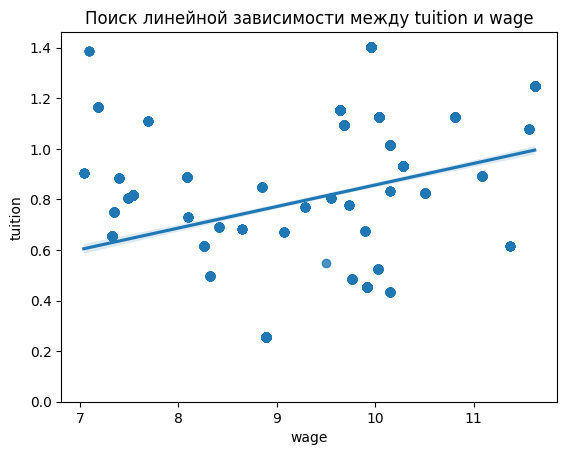

In [10]:
sns.regplot(x="wage", y="tuition", data=df)
plt.title("Поиск линейной зависимости между tuition и wage")
plt.ylim(0,)
plt.show()

Формирование матрицы X и вектора y

In [11]:
cat_vars=['gender', 'ethnicity', 'fcollege', 'mcollege', 'home', 'urban', 'income', 'region'] # категориальные переменные датасета
num_vars = ['score', 'unemp', 'wage', 'distance', 'education'] # числовые переменные
target_var = ['tuition'] #  целевая переменная
X_dummies = pd.get_dummies(df[cat_vars], drop_first = True, dtype = int) # кодиреуем 8 исходных категориальных переменных в 9 числовых
X = df[num_vars].merge(right = X_dummies, how = 'inner', left_index = True, right_index = True) # формируем матрицу X из числовых и перекодированных переменных
y = df[target_var] # формируем вектор y
X

,score,unemp,wage,distance,education,gender_male,ethnicity_hispanic,ethnicity_other,fcollege_yes,mcollege_yes,home_yes,urban_yes,income_low,region_west
rownames,,,,,,,,,,,,,,
1,39.150002,6.2,8.09,0.2,12,1,0,1,1,0,1,1,0,0
2,48.869999,6.2,8.09,0.2,12,0,0,1,0,0,1,1,1,0
3,48.740002,6.2,8.09,0.2,12,1,0,1,0,0,1,1,1,0
4,40.400002,6.2,8.09,0.2,12,1,0,0,0,0,1,1,1,0
5,40.480000,5.6,8.09,0.4,13,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9391,56.529999,6.6,8.89,0.8,13,1,0,0,0,0,1,0,0,1
9401,59.770000,6.6,8.89,0.8,15,1,0,0,0,0,1,0,0,1
9411,43.169998,6.6,8.89,0.8,12,1,0,1,0,0,1,0,0,1


Деление выборки на обучающую, тестовую и прогнозную

In [12]:
X0=X[['wage']] # Используем только столбец wage
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(X0, y)

Обучение моделей

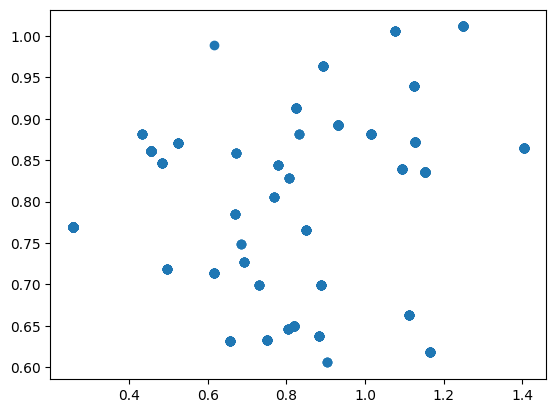

Метрики:
         TEXT        R2       MAE      RMSE      MAPE
0  OLS (wage)  0.079988  0.277982  0.325701  0.552804



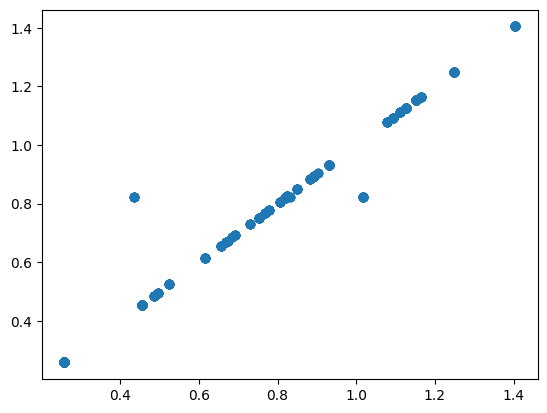

Метрики:
                   TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (wage)  0.979906  0.008504  0.048134  0.012968



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


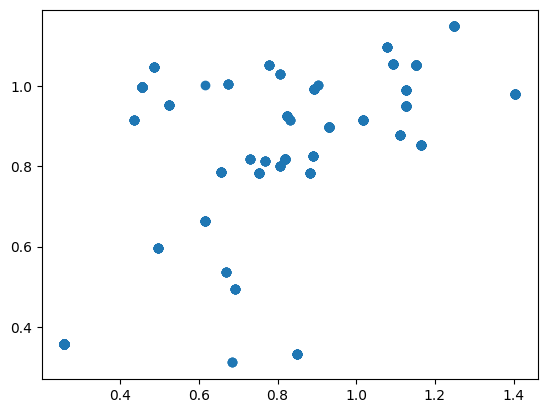

Метрики:
         TEXT        R2       MAE      RMSE      MAPE
0  SVM (wage)  0.425503  0.185832  0.257375  0.321472



In [13]:
# Модель Linear Regression (OLS)
ols = linear_model.LinearRegression()
y_pred=model_test(ols, "OLS (wage)", X_train, y_train, X_test, y_test)

# Модель Decision Tree
regr_tree = tree.DecisionTreeRegressor()
y_pred=model_test(regr_tree, "Decision Tree (wage)", X_train, y_train, X_test, y_test)

# Модель Support Vector Machines (SVM)
regr_svm = svm.SVR()
y_pred=model_test(regr_svm, "SVM (wage)", X_train, y_train, X_test, y_test)

На основании метрик и графиков делаем вывод о том, что наилучшее качество предсказаний дает модель Decision Tree. Судя по метрикам, результат Decision Tree приемлем. Ниже попытаемся увеличить качество моделей

Оценим качество всех моделей при использовании всех переменных в матрице X

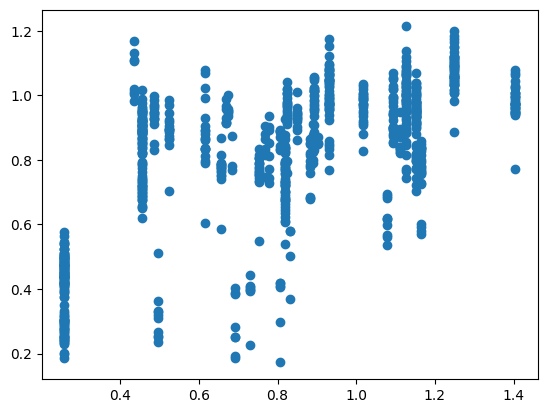

Метрики:
             TEXT        R2       MAE      RMSE      MAPE
0  OLS (all vars)  0.429476  0.209219  0.256484  0.345588



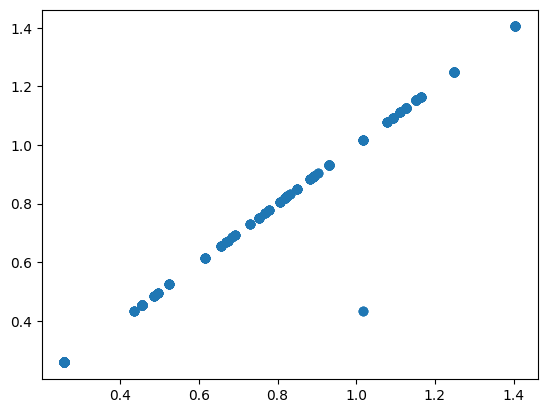

Метрики:
                       TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (all vars)  0.990131  0.001955  0.033733  0.001924



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


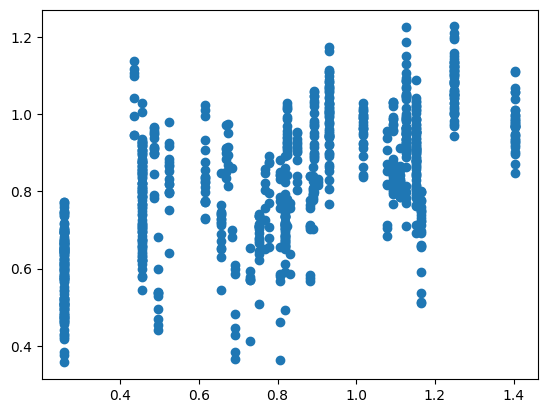

Метрики:
             TEXT        R2       MAE      RMSE      MAPE
0  SVM (all vars)  0.380152  0.224538  0.267341  0.424048



In [14]:
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(X, y)
y_pred=model_test(ols, "OLS (all vars)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_tree, "Decision Tree (all vars)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_svm, "SVM (all vars)", X_train, y_train, X_test, y_test)

При использовании всех переменных возрасло качество модели OLS, но лучшей моделью по-прежнему является модель Decision Tree

Произведем нормализацию и повторно оценим качество всех моделей

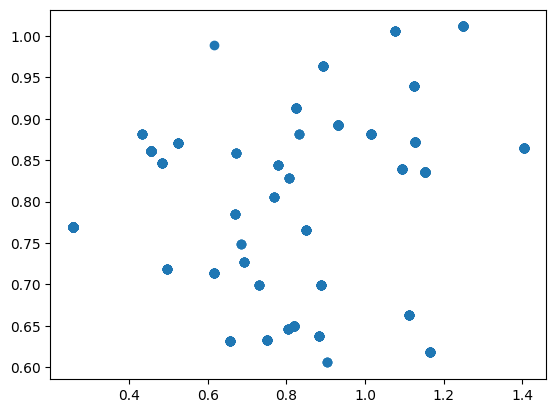

Метрики:
              TEXT        R2       MAE      RMSE      MAPE
0  OLS (wage norm)  0.079988  0.277982  0.325701  0.552804



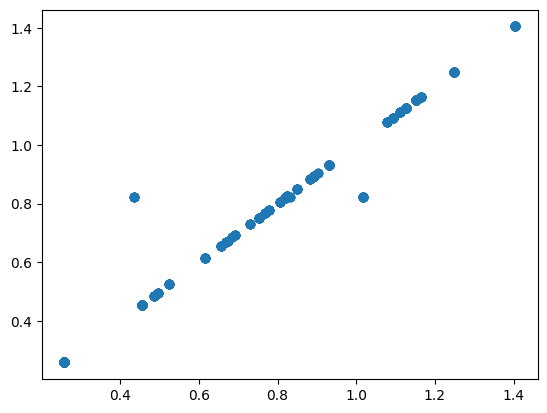

Метрики:
                        TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (wage norm)  0.979906  0.008504  0.048134  0.012968



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


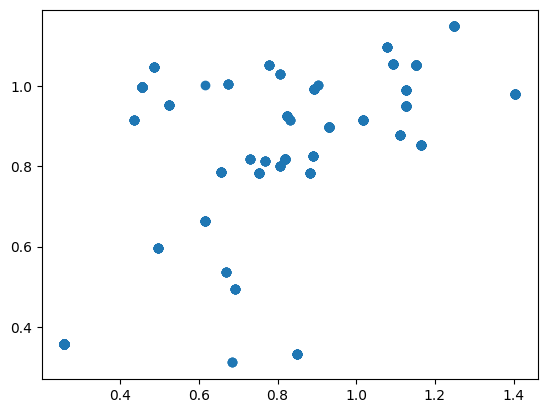

Метрики:
              TEXT        R2       MAE      RMSE      MAPE
0  SVM (wage norm)  0.425503  0.185832  0.257375  0.321472



In [15]:
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(lambda_norm(X0), y)
y_pred=model_test(ols, "OLS (wage norm)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_tree, "Decision Tree (wage norm)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_svm, "SVM (wage norm)", X_train, y_train, X_test, y_test)

Нормализация не увеличила качество первоначальных предсказаний моделей. Вероятно, нормализация предусмотрена в алгоритме самих моделей

Оценим качество всех моделей при возведении матрицы X0 в квадрат

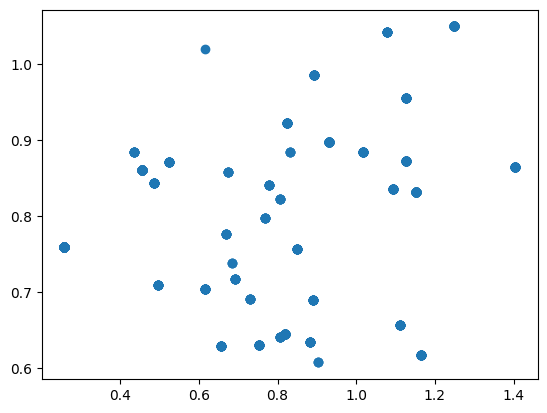

Метрики:
             TEXT        R2       MAE      RMSE      MAPE
0  OLS (wage sqr)  0.097601  0.274748  0.322569  0.545682



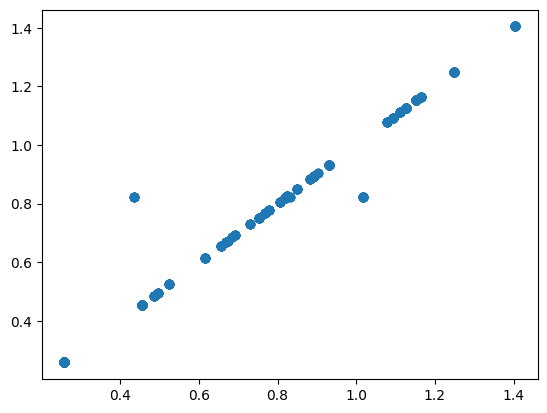

Метрики:
                       TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (wage sqr)  0.979906  0.008504  0.048134  0.012968



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


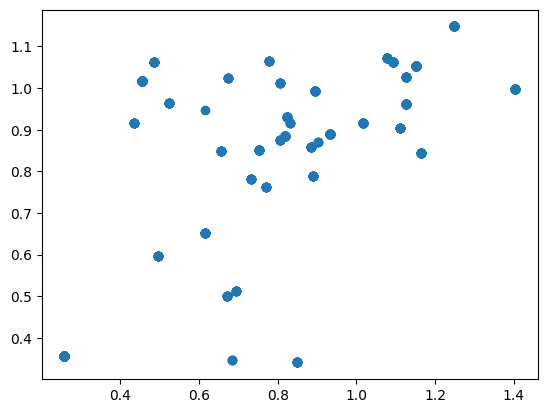

Метрики:
             TEXT        R2       MAE      RMSE      MAPE
0  SVM (wage sqr)  0.403642  0.191995  0.262226  0.332805



In [16]:
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(np.square(X0), y)
y_pred=model_test(ols, "OLS (wage sqr)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_tree, "Decision Tree (wage sqr)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_svm, "SVM (wage sqr)", X_train, y_train, X_test, y_test)

Качество моделей близко к первоначальному

Оценим качество всех моделей при взятии логарифма матрицы X0

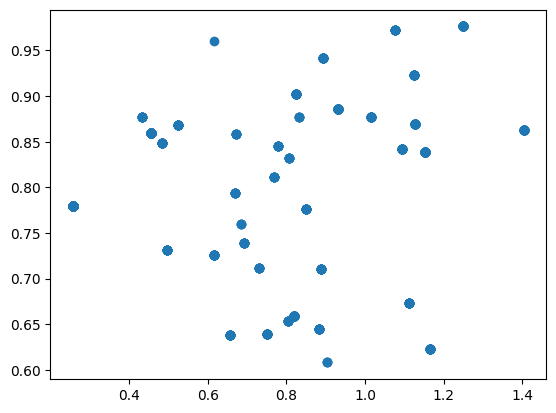

Метрики:
             TEXT        R2       MAE      RMSE      MAPE
0  OLS (wage log)  0.062814  0.280603  0.328727  0.558845



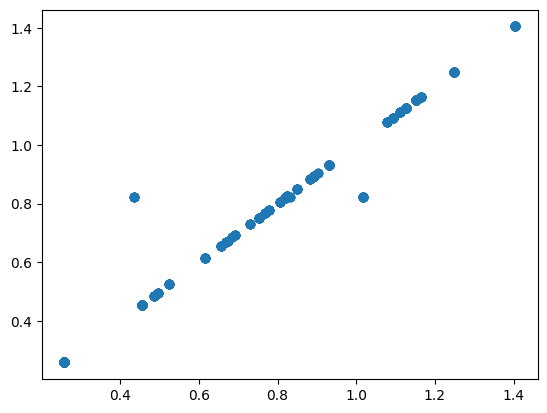

Метрики:
                       TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (wage log)  0.979906  0.008504  0.048134  0.012968



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


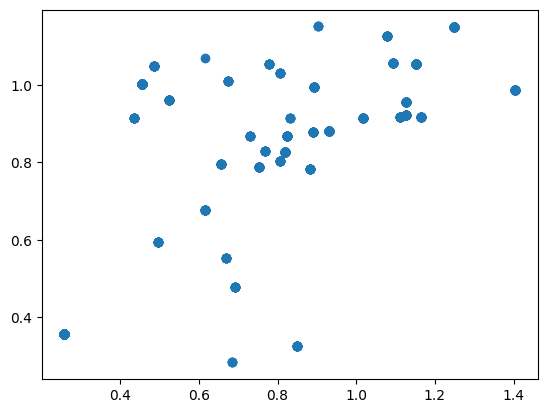

Метрики:
             TEXT        R2       MAE      RMSE      MAPE
0  SVM (wage log)  0.422504  0.186874  0.258046  0.324246



In [17]:
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(np.log(X0), y)
y_pred=model_test(ols, "OLS (wage log)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_tree, "Decision Tree (wage log)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_svm, "SVM (wage log)", X_train, y_train, X_test, y_test)

Качество моделей близко к первоначальному

Добавим в модель фактор нахождения в городской местности и повторно оценим качество всех моделей

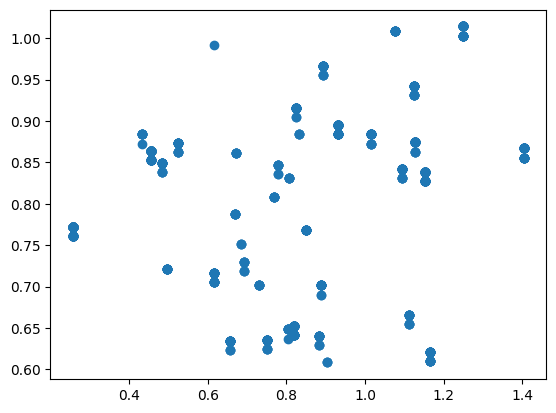

Метрики:
                    TEXT        R2       MAE      RMSE      MAPE
0  OLS (wage, urban_yes)  0.079639  0.278049  0.325763  0.552594



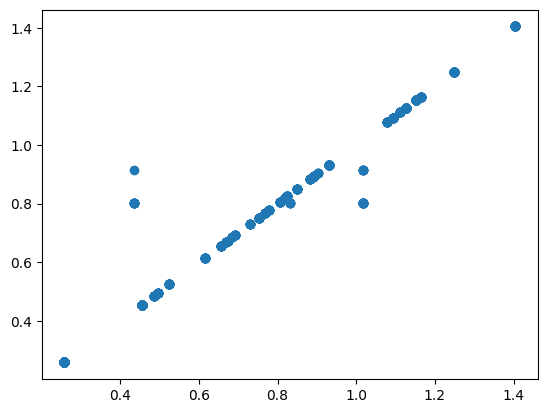

Метрики:
                              TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (wage, urban_yes)  0.979974  0.008458  0.048053  0.012854



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


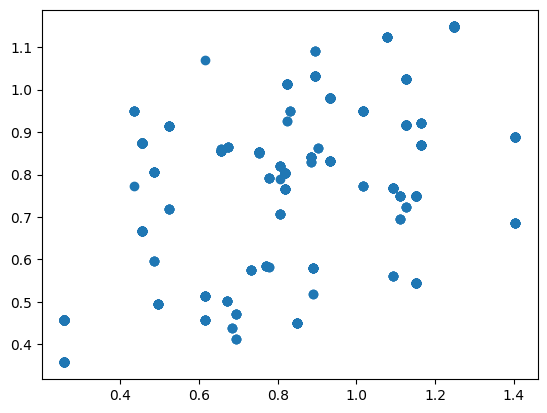

Метрики:
                    TEXT        R2       MAE      RMSE      MAPE
0  SVM (wage, urban_yes)  0.320604  0.227453  0.279888  0.356937



In [18]:
X1=X[['wage', 'urban_yes']] # Используем столбцы wage и urban_yes
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(lambda_norm(X1), y)
y_pred=model_test(ols, "OLS (wage, urban_yes)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_tree, "Decision Tree (wage, urban_yes)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_svm, "SVM (wage, urban_yes)", X_train, y_train, X_test, y_test)

Качество моделей OLS, Decision Tree практически без изменений, качество модели SVM упало

Добавим в модель расстояние и повторно оценим качество всех моделей

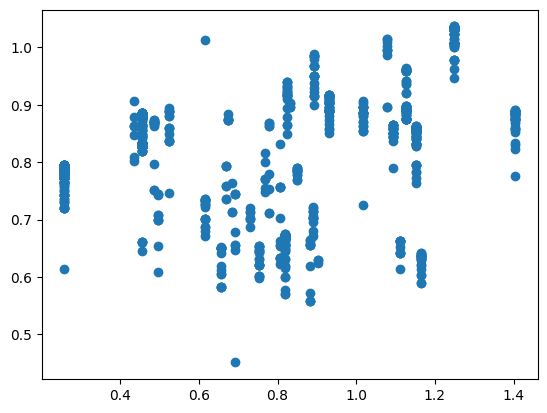

Метрики:
                   TEXT        R2       MAE      RMSE      MAPE
0  OLS (wage, distance)  0.090941  0.274195  0.323757  0.549467



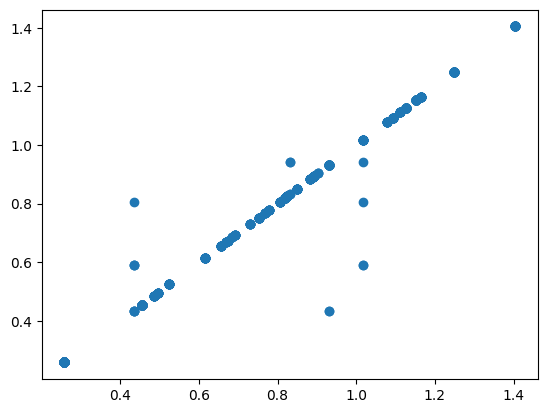

Метрики:
                             TEXT       R2       MAE      RMSE      MAPE
0  Decision Tree (wage, distance)  0.98889  0.003575  0.035791  0.004906



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


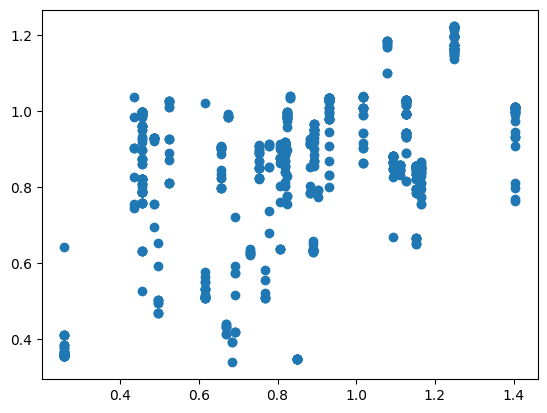

Метрики:
                   TEXT        R2       MAE      RMSE      MAPE
0  SVM (wage, distance)  0.422658  0.206505  0.258012  0.328027



In [19]:
X1=X[['wage', 'distance']] # Используем столбцы wage и distance
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(lambda_norm(X1), y)
y_pred=model_test(ols, "OLS (wage, distance)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_tree, "Decision Tree (wage, distance)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_svm, "SVM (wage, distance)", X_train, y_train, X_test, y_test)

Качество моделей близко к первоначальному

In [20]:
print (f"Итоговая таблица с метриками:\n {df_metrics.reset_index(drop=True)}")

Итоговая таблица с метриками:
                                TEXT        R2       MAE      RMSE      MAPE
0                        OLS (wage)  0.079988  0.277982  0.325701  0.552804
1              Decision Tree (wage)  0.979906  0.008504  0.048134  0.012968
2                        SVM (wage)  0.425503  0.185832  0.257375  0.321472
3                    OLS (all vars)  0.429476  0.209219  0.256484  0.345588
4          Decision Tree (all vars)  0.990131  0.001955  0.033733  0.001924
5                    SVM (all vars)  0.380152  0.224538  0.267341  0.424048
6                   OLS (wage norm)  0.079988  0.277982  0.325701  0.552804
7         Decision Tree (wage norm)  0.979906  0.008504  0.048134  0.012968
8                   SVM (wage norm)  0.425503  0.185832  0.257375  0.321472
9                    OLS (wage sqr)  0.097601  0.274748  0.322569  0.545682
10         Decision Tree (wage sqr)  0.979906  0.008504  0.048134  0.012968
11                   SVM (wage sqr)  0.403642  0.191995  

На основании выведенной статистики в качестве наилучшей модели примем модель Decision Tree для переменной wage, так как она с одной стороны обладает одинм из больших значением R2, а также почти самыми малыми значениями MAE, RMSE, MAPE, а с другой стороны проста в обосновании взаимосвязей.

Сделаем предсказание на основе оставшихся 20% выборки

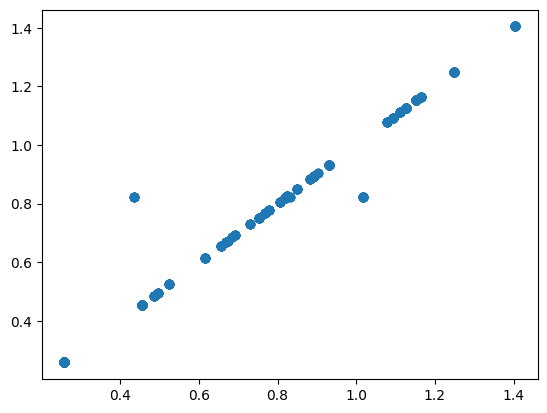

Метрики:
                   TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (wage)  0.979906  0.008504  0.048134  0.012968



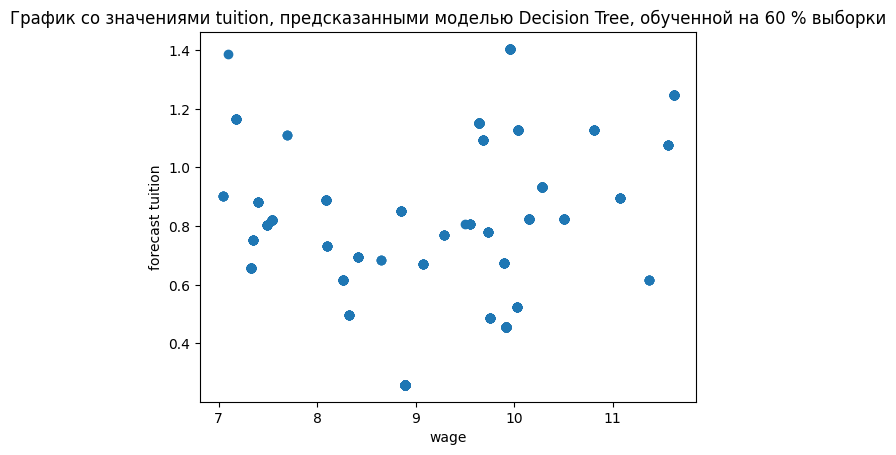

In [21]:
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(X0, y)
y_pred=model_test(regr_tree, "Decision Tree (wage)", X_train, y_train, X_test, y_test)
y_pred=regr_tree.predict(X_forecast)
plt.scatter(X_forecast, y_pred)
plt.title ("График со значениями tuition, предсказанными моделью Decision Tree, обученной на 60 % выборки")
plt.xlabel("wage")
plt.ylabel("forecast tuition")
plt.show()